In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras_applications.mobilenet import MobileNet
from keras_applications.mobilenet_v2 import MobileNetV2
from keras.layers import Reshape, Conv2D, Input, Lambda
from keras_applications.mobilenet import _depthwise_conv_block
from keras_applications.mobilenet_v2 import _inverted_res_block

%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1" 

In [4]:
def read_category():
    category = []
    with open('./UECFOOD100_JS/category.txt', 'r') as file:
        for i, line in enumerate(file):
            if i > 0:
                line = line.rstrip('\n')
                line = line.split('\t')
                category.append(line[1])
    return category

In [5]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, c=None, classes=None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax

        self.c = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

In [6]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2, x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2, x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax - box1.xmin, box1.ymax - box1.ymin
    w2, h2 = box2.xmax - box2.xmin, box2.ymax - box2.ymin

    union = w1 * h1 + w2 * h2 - intersect

    return float(intersect) / union

In [7]:
import copy
import os
import xml.etree.ElementTree as ET

import cv2
import numpy as np
from imgaug import augmenters as iaa
from keras.utils import Sequence

def parse_annotation(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}

    for ann in sorted(os.listdir(ann_dir)):
        img = {'object': []}

        tree = ET.parse(ann_dir + ann)

        for elem in tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = img_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}

                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1

                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]

                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]

    return all_imgs, seen_labels


class BatchGenerator(Sequence):
    def __init__(self, images,
                 config,
                 shuffle=True,
                 jitter=True,
                 norm=None):
        self.generator = None

        self.images = images
        self.config = config

        self.shuffle = shuffle
        self.jitter = jitter
        self.norm = norm

        self.anchors = [BoundBox(0, 0, config['ANCHORS'][2 * i], config['ANCHORS'][2 * i + 1]) for i in
                        range(int(len(config['ANCHORS']) // 2))]

        ### augmentors by https://github.com/aleju/imgaug
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        # Define our sequence of augmentation steps that will be applied to every image
        # All augmenters with per_channel=0.5 will sample one value _per image_
        # in 50% of all cases. In all other cases they will sample new values
        # _per channel_.
        self.aug_pipe = iaa.Sequential(
            [
                # apply the following augmenters to most images
                # iaa.Fliplr(0.5), # horizontally flip 50% of all images
                # iaa.Flipud(0.2), # vertically flip 20% of all images
                # sometimes(iaa.Crop(percent=(0, 0.1))), # crop images by 0-10% of their height/width
                sometimes(iaa.Affine(
                    # scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                    # translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                    # rotate=(-5, 5), # rotate by -45 to +45 degrees
                    # shear=(-5, 5), # shear by -16 to +16 degrees
                    # order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    # cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    # mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                )),
                # execute 0 to 5 of the following (less important) augmenters per image
                # don't execute all of them, as that would often be way too strong
                iaa.SomeOf((0, 5),
                           [
                               # sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                               iaa.OneOf([
                                   iaa.GaussianBlur((0, 3.0)),  # blur images with a sigma between 0 and 3.0
                                   iaa.AverageBlur(k=(2, 7)),
                                   # blur image using local means with kernel sizes between 2 and 7
                                   iaa.MedianBlur(k=(3, 11)),
                                   # blur image using local medians with kernel sizes between 2 and 7
                               ]),
                               iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # sharpen images
                               # iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                               # search either for all edges or for directed edges
                               # sometimes(iaa.OneOf([
                               #    iaa.EdgeDetect(alpha=(0, 0.7)),
                               #    iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0)),
                               # ])),
                               iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
                               # add gaussian noise to images
                               iaa.OneOf([
                                   iaa.Dropout((0.01, 0.1), per_channel=0.5),  # randomly remove up to 10% of the pixels
                                   # iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                               ]),
                               # iaa.Invert(0.05, per_channel=True), # invert color channels
                               iaa.Add((-10, 10), per_channel=0.5),
                               # change brightness of images (by -10 to 10 of original value)
                               iaa.Multiply((0.5, 1.5), per_channel=0.5),
                               # change brightness of images (50-150% of original value)
                               iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),  # improve or worsen the contrast
                               # iaa.Grayscale(alpha=(0.0, 1.0)),
                               # sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                               # sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))) # sometimes move parts of the image around
                           ],
                           random_order=True
                           )
            ],
            random_order=True
        )

        if shuffle: np.random.shuffle(self.images)

    def __len__(self):
        return int(np.ceil(float(len(self.images)) / self.config['BATCH_SIZE']))

    def num_classes(self):
        return len(self.config['LABELS'])

    def size(self):
        return len(self.images)

    def load_annotation(self, i):
        annots = []

        for obj in self.images[i]['object']:
            annot = [obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'], self.config['LABELS'].index(obj['name'])]
            annots += [annot]

        if len(annots) == 0:
            annots = [[]]

        return np.array(annots)

    def load_image(self, i):
        return cv2.imread(self.images[i]['filename'])

    def __getitem__(self, idx):
        l_bound = idx * self.config['BATCH_SIZE']
        r_bound = (idx + 1) * self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0

        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))  # input images
        b_batch = np.zeros((r_bound - l_bound, 1, 1, 1, self.config['TRUE_BOX_BUFFER'],
                            4))  # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'], self.config['GRID_W'], self.config['BOX'],
                            4 + 1 + len(self.config['LABELS'])))  # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.aug_image(train_instance, jitter=self.jitter)

            # construct output from object's x, y, w, h
            true_box_index = 0

            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x = .5 * (obj['xmin'] + obj['xmax'])
                    center_x = center_x / (float(self.config['IMAGE_W']) / self.config['GRID_W'])
                    center_y = .5 * (obj['ymin'] + obj['ymax'])
                    center_y = center_y / (float(self.config['IMAGE_H']) / self.config['GRID_H'])

                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx = self.config['LABELS'].index(obj['name'])

                        center_w = (obj['xmax'] - obj['xmin']) / (
                                    float(self.config['IMAGE_W']) / self.config['GRID_W'])  # unit: grid cell
                        center_h = (obj['ymax'] - obj['ymin']) / (
                                    float(self.config['IMAGE_H']) / self.config['GRID_H'])  # unit: grid cell

                        box = [center_x, center_y, center_w, center_h]

                        # find the anchor that best predicts this box
                        best_anchor = -1
                        max_iou = -1

                        shifted_box = BoundBox(0,
                                               0,
                                               center_w,
                                               center_h)

                        for i in range(len(self.anchors)):
                            anchor = self.anchors[i]
                            iou = bbox_iou(shifted_box, anchor)

                            if max_iou < iou:
                                best_anchor = i
                                max_iou = iou

                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4] = 1.
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5 + obj_indx] = 1

                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box

                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']

            # assign input image to x_batch
            if self.norm != None:
                x_batch[instance_count] = self.norm(img)
            else:
                # plot image and bounding boxes for sanity check
                for obj in all_objs:
                    if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin']:
                        cv2.rectangle(img[:, :, ::-1], (obj['xmin'], obj['ymin']), (obj['xmax'], obj['ymax']),
                                      (255, 0, 0), 3)
                        cv2.putText(img[:, :, ::-1], obj['name'],
                                    (obj['xmin'] + 2, obj['ymin'] + 12),
                                    0, 1.2e-3 * img.shape[0],
                                    (0, 255, 0), 2)

                x_batch[instance_count] = img

            # increase instance counter in current batch
            instance_count += 1

            # print(' new batch created', idx)

        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.images)

    def aug_image(self, train_instance, jitter):
        image_name = train_instance['filename']
        image = cv2.imread(image_name)

        if image is None:
            print('Cannot find ', image_name)

        h, w, c = image.shape
        all_objs = copy.deepcopy(train_instance['object'])

        if jitter:
            ### scale the image
            scale = np.random.uniform() / 10. + 1.
            image = cv2.resize(image, (0, 0), fx=scale, fy=scale)

            ### translate the image
            max_offx = (scale - 1.) * w
            max_offy = (scale - 1.) * h
            offx = int(np.random.uniform() * max_offx)
            offy = int(np.random.uniform() * max_offy)

            image = image[offy: (offy + h), offx: (offx + w)]

            ### flip the image
            flip = np.random.binomial(1, .5)
            if flip > 0.5: image = cv2.flip(image, 1)

            image = self.aug_pipe.augment_image(image)

        # resize the image to standard size
        image = cv2.resize(image, (self.config['IMAGE_H'], self.config['IMAGE_W']))
        image = image[:, :, ::-1]

        # fix object's position and size
        for obj in all_objs:
            for attr in ['xmin', 'xmax']:
                if jitter: obj[attr] = int(obj[attr] * scale - offx)

                obj[attr] = int(obj[attr] * float(self.config['IMAGE_W']) / w)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_W']), 0)

            for attr in ['ymin', 'ymax']:
                if jitter: obj[attr] = int(obj[attr] * scale - offy)

                obj[attr] = int(obj[attr] * float(self.config['IMAGE_H']) / h)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_H']), 0)

            if jitter and flip > 0.5:
                xmin = obj['xmin']
                obj['xmin'] = self.config['IMAGE_W'] - obj['xmax']
                obj['xmax'] = self.config['IMAGE_W'] - xmin

        return image, all_objs


In [8]:
''' Initiailize parameters '''
LABELS = read_category()

IMAGE_H, IMAGE_W = 224, 224  # must equal to GRID_H * 32  416, 416
GRID_H, GRID_W = 7, 7        # 13, 13
N_BOX = 5
CLASS = len(LABELS)
CLASS_WEIGHTS = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD = 0.3
NMS_THRESHOLD = 0.3

# Read knn generated anchor_5.txt
ANCHORS = []
with open('./UECFOOD100_JS/generated_anchors_mobilenet/anchors_5.txt', 'r') as anchor_file:
    for i, line in enumerate(anchor_file):
        line = line.rstrip('\n')
        ANCHORS.append(list(map(float, line.split(', '))))
ANCHORS = list(list(np.array(ANCHORS).reshape(1, -1))[0])

NO_OBJECT_SCALE = 1.0
OBJECT_SCALE = 5.0
COORD_SCALE = 1.0
CLASS_SCALE = 1.0

BATCH_SIZE = 16
WARM_UP_BATCHES = 100
TRUE_BOX_BUFFER = 50

generator_config = {
    'IMAGE_H': IMAGE_H,
    'IMAGE_W': IMAGE_W,
    'GRID_H': GRID_H,
    'GRID_W': GRID_W,
    'BOX': N_BOX,
    'LABELS': LABELS,
    'CLASS': len(LABELS),
    'ANCHORS': ANCHORS,
    'BATCH_SIZE': BATCH_SIZE,
    'TRUE_BOX_BUFFER': TRUE_BOX_BUFFER,
}

all_imgs = []
for i in range(0, len(LABELS)):
    image_path = './UECFOOD100_JS/' + str(i+1) + '/'
    annot_path = './UECFOOD100_JS/' + str(i+1) + '/' + '/annotations_new/'

    folder_imgs, seen_labels = parse_annotation(annot_path, image_path)
    all_imgs.extend(folder_imgs)
print(np.array(all_imgs).shape)

(14361,)


=> Generate BatchGenerator.


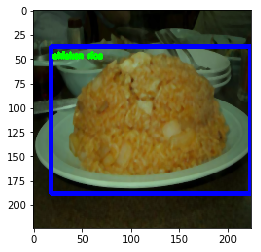

In [9]:
print('=> Generate BatchGenerator.')
batches = BatchGenerator(all_imgs, generator_config)

img = batches[0][0][0][5]
plt.imshow(img.astype('uint8'))

In [61]:
def get_model():
    """ Build MobileNetV1 model """
    print('=> Building MobileNetV1 model...')
    mobilenetv2 = MobileNetV2(input_shape=(224, 224, 3), include_top=False)
    x = mobilenetv2(input_image)
    x = Conv2D(N_BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, N_BOX, 4 + 1 + CLASS))(x)

    # small hack to allow true_boxes to be registered when Keras build the model
    # for more information: https://github.com/fchollet/keras/issues/2790
    output = Lambda(lambda args: args[0])([output, true_boxes])

    model = Model([input_image, true_boxes], output)
    print(model.summary())
    return model

In [16]:
def get_mn2_model():
    """ Build MobileNetV1 model """
    print('=> Building MobileNetV1 model...')
    mobilenetv2 = MobileNetV2(input_shape=(224, 224, 3), include_top=False)
    x = mobilenetv2(input_image)
    x = Conv2D(N_BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, N_BOX, 4 + 1 + CLASS))(x)

    # small hack to allow true_boxes to be registered when Keras build the model
    # for more information: https://github.com/fchollet/keras/issues/2790
    output = Lambda(lambda args: args[0])([output, true_boxes])

    model = Model([input_image, true_boxes], output)
    print(model.summary())
    return model

In [16]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [42]:
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
import tensorflow as tf

def get_darknet():
    
    input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
#     true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

    # Layer 1
    x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
    x = BatchNormalization(name='norm_1')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 2
    x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
    x = BatchNormalization(name='norm_2')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 3
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
    x = BatchNormalization(name='norm_3')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 4
    x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
    x = BatchNormalization(name='norm_4')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 5
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
    x = BatchNormalization(name='norm_5')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 6
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
    x = BatchNormalization(name='norm_6')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 7
    x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
    x = BatchNormalization(name='norm_7')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 8
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
    x = BatchNormalization(name='norm_8')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 9
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
    x = BatchNormalization(name='norm_9')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 10
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
    x = BatchNormalization(name='norm_10')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 11
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
    x = BatchNormalization(name='norm_11')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 12
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
    x = BatchNormalization(name='norm_12')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 13
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
    x = BatchNormalization(name='norm_13')(x)
    x = LeakyReLU(alpha=0.1)(x)

    skip_connection = x

    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 14
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
    x = BatchNormalization(name='norm_14')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 15
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
    x = BatchNormalization(name='norm_15')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 16
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
    x = BatchNormalization(name='norm_16')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 17
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
    x = BatchNormalization(name='norm_17')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 18
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
    x = BatchNormalization(name='norm_18')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 19
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
    x = BatchNormalization(name='norm_19')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 20
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
    x = BatchNormalization(name='norm_20')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 21
    skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
    skip_connection = BatchNormalization(name='norm_21')(skip_connection)
    skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
    skip_connection = Lambda(space_to_depth_x2)(skip_connection)

    x = concatenate([skip_connection, x])

    # Layer 22
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
    x = BatchNormalization(name='norm_22')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 23
    x = Conv2D(N_BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, N_BOX, 4 + 1 + CLASS))(x)

    # small hack to allow true_boxes to be registered when Keras build the model 
    # for more information: https://github.com/fchollet/keras/issues/2790
    output = Lambda(lambda args: args[0])([output, true_boxes])

    model = Model([input_image, true_boxes], output)
#     print(model.summary())
    return model

In [102]:
def get_pretrained_darknet():
    input_image = Input(shape=(416, 416, 3))

    # Layer 1
    x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
    x = BatchNormalization(name='norm_1')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 2
    x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
    x = BatchNormalization(name='norm_2')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 3
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
    x = BatchNormalization(name='norm_3')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 4
    x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
    x = BatchNormalization(name='norm_4')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 5
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
    x = BatchNormalization(name='norm_5')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 6
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
    x = BatchNormalization(name='norm_6')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 7
    x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
    x = BatchNormalization(name='norm_7')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 8
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
    x = BatchNormalization(name='norm_8')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 9
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
    x = BatchNormalization(name='norm_9')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 10
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
    x = BatchNormalization(name='norm_10')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 11
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
    x = BatchNormalization(name='norm_11')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 12
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
    x = BatchNormalization(name='norm_12')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 13
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
    x = BatchNormalization(name='norm_13')(x)
    x = LeakyReLU(alpha=0.1)(x)

    skip_connection = x

    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 14
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
    x = BatchNormalization(name='norm_14')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 15
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
    x = BatchNormalization(name='norm_15')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 16
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
    x = BatchNormalization(name='norm_16')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 17
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
    x = BatchNormalization(name='norm_17')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 18
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
    x = BatchNormalization(name='norm_18')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 19
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
    x = BatchNormalization(name='norm_19')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 20
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
    x = BatchNormalization(name='norm_20')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 21
    skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
    skip_connection = BatchNormalization(name='norm_21')(skip_connection)
    skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
    skip_connection = Lambda(space_to_depth_x2)(skip_connection)

    x = concatenate([skip_connection, x])

    # Layer 22
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
    x = BatchNormalization(name='norm_22')(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    base_model = Model(inputs=input_image, outputs=x)
#     print(base_model.summary())
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.33)(x)
    x = layers.Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    print(model.summary())
    model.load_weights('../food-classifier/model/darknet_416_foodornot_2.h5')
    
    model = Model(inputs=model.input, outputs=model.layers[-3].input)
    x = model.output
    x = Conv2D(N_BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, N_BOX, 4 + 1 + CLASS))(x)
    output = Lambda(lambda args: args[0])([output, true_boxes])

    model = Model([input_image, true_boxes], output)
    print(model.summary())
    print('Done with tla darknet model')
    
    return model

In [10]:
import nbimporter
from ResNet34 import ResnetBuilder
from keras import backend as K

def get_normal_resnet34():
    K.set_image_dim_ordering('tf')
    resnet34 = ResnetBuilder.build_resnet_34((3, 224, 224), 1)
    
    model = Model(inputs=resnet34.input, outputs=resnet34.layers[-3].input)
    
    x = model(input_image)
    x = Conv2D(N_BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, N_BOX, 4 + 1 + CLASS))(x)
    output = Lambda(lambda args: args[0])([output, true_boxes])
    
    model = Model([input_image, true_boxes], output)
    
    print(model.summary())
    
    print('built normal resnet34 network with yolov2 output')
    return model

Importing Jupyter notebook from ResNet34.ipynb


In [11]:
def get_tla_resnet34():
    print('=> Building new model with pretrained ResNet34...')

    pretrained_gap_model = load_model('./rn34_224_foodornot_2.h5')
#     print(pretrained_gap_model.summary())
    
    model = Model(inputs=pretrained_gap_model.input, outputs=pretrained_gap_model.layers[-3].input)
#     print(model.summary())
    
    x = model(input_image)
    x = Conv2D(N_BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, N_BOX, 4 + 1 + CLASS))(x)
    output = Lambda(lambda args: args[0])([output, true_boxes])
    
    model = Model([input_image, true_boxes], output)
    
    print(model.summary())
    print('Finish new model.')
    return model

In [11]:
model = get_mn2_model()

=> Building MobileNetV1 model...



KeyboardInterrupt



In [48]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 112, 112, 64) 256         conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 112, 112, 64) 0           batch_normalization_34[0][0]     
__________________________________________________________________________________________________
max_poolin

In [103]:
def get_pretrained_mn1():
    alpha, depth_multiplier = 1, 1
    print('=> Building new model with pretrained MobilenetV1...')

    pretrained_gap_model = load_model('./gap_foodnotfood_mn1_224.h5')
    print(pretrained_gap_model.summary())
    
    model = Model(inputs=pretrained_gap_model.input, outputs=pretrained_gap_model.layers[-6].input)
    print(model.summary())
    
    x = model(input_image)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier,
                              strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)

    x = Conv2D(N_BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, N_BOX, 4 + 1 + CLASS))(x)
    output = Lambda(lambda args: args[0])([output, true_boxes])

    model = Model([input_image, true_boxes], output)
    print(model.summary())
    print('Finish new model.')
    return model

In [104]:
def get_pretrained_mn2():
    alpha, depth_multiplier = 1, 1
    print('=> Building new model with pretrained MobilenetV2...')
    print('pretrained_gap_model.summary()\n')
          
    pretrained_gap_model = load_model('./mnv2_224_foodvsnot_3.h5')
    print(pretrained_gap_model.summary())
    
    model = Model(inputs=pretrained_gap_model.input, outputs=pretrained_gap_model.layers[-6].input)
    print(model.summary())
    
    x = model(input_image)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2,
                            expansion=6, block_id=13)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=14)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=15)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1,
                            expansion=6, block_id=16)

    x = Conv2D(N_BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, N_BOX, 4 + 1 + CLASS))(x)
    output = Lambda(lambda args: args[0])([output, true_boxes])

    model = Model([input_image, true_boxes], output)
    print(model.summary())
    print('Finish new model.')
    return model

In [12]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]

    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0, 2, 1, 3, 4))

    cell_grid = tf.tile(tf.concat([cell_x, cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])

    coord_mask = tf.zeros(mask_shape)
    conf_mask = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)

    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)

    """ Adjust prediction """
    # adjust x and y
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid

    # adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1, 1, 1, N_BOX, 2])

    # adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])

    # adjust class probabilities
    pred_box_class = y_pred[..., 5:]

    """ Adjust ground truth """
    # adjust x and y
    true_box_xy = y_true[..., 0:2]  # relative position to the containing cell

    # adjust w and h
    true_box_wh = y_true[..., 2:4]  # number of cells accross, horizontally and vertically

    # adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins = true_box_xy - true_wh_half
    true_maxes = true_box_xy + true_wh_half

    pred_wh_half = pred_box_wh / 2.
    pred_mins = pred_box_xy - pred_wh_half
    pred_maxes = pred_box_xy + pred_wh_half

    intersect_mins = tf.maximum(pred_mins, true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = tf.truediv(intersect_areas, union_areas)

    true_box_conf = iou_scores * y_true[..., 4]

    # adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)

    """ Determine the masks """
    # coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE

    # confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]

    true_wh_half = true_wh / 2.
    true_mins = true_xy - true_wh_half
    true_maxes = true_xy + true_wh_half

    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)

    pred_wh_half = pred_wh / 2.
    pred_mins = pred_xy - pred_wh_half
    pred_maxes = pred_xy + pred_wh_half

    intersect_mins = tf.maximum(pred_mins, true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE

    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE

    # class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE

    """ Warm-up training """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE / 2.)
    seen = tf.assign_add(seen, 1.)

    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES),
                                                   lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask,
                                                            true_box_wh + tf.ones_like(true_box_wh) * np.reshape(
                                                                ANCHORS, [1, 1, 1, N_BOX, 2]) * no_boxes_mask,
                                                            tf.ones_like(coord_mask)],
                                                   lambda: [true_box_xy,
                                                            true_box_wh,
                                                            coord_mask])

    """ Finalize the loss """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box = tf.reduce_sum(tf.to_float(conf_mask > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))

    loss_xy = tf.reduce_sum(tf.square(true_box_xy - pred_box_xy) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh = tf.reduce_sum(tf.square(true_box_wh - pred_box_wh) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf = tf.reduce_sum(tf.square(true_box_conf - pred_box_conf) * conf_mask) / (nb_conf_box + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)

    loss = loss_xy + loss_wh + loss_conf + loss_class

    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """ Debugging code """
    current_recall = nb_pred_box / (nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall)

    loss = tf.Print(loss, [tf.zeros((1))], message='\nDummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall / seen], message='Average Recall \t', summarize=1000)

    return loss

In [13]:
def normalize(image):
    return image / 255.

In [17]:
''' Start training '''
train_valid_split = int(0.8 * len(all_imgs))

train_batch = BatchGenerator(all_imgs[:train_valid_split], generator_config, norm=normalize, jitter=False)
valid_batch = BatchGenerator(all_imgs[train_valid_split:], generator_config, norm=normalize, jitter=False)

input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER, 4))

# model = get_pretrained_darknet()
model = get_mn2_model()
# model = get_normal_resnet34()

=> Building MobileNetV1 model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Model)    (None, 7, 7, 1280)   2257984     input_5[0][0]                    
__________________________________________________________________________________________________
conv_23 (Conv2D)                (None, 7, 7, 525)    672525      mobilenetv2_1.00_224[1][0]       
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 7, 7, 5, 105) 0           conv_23[0][0]                    
____________________________________________________________________________

In [20]:
def train(model):

    layer = model.layers[-4]            # the last convolutional layer
    weights = layer.get_weights()

    new_kernel = np.random.normal(size=weights[0].shape) / (GRID_H * GRID_W)
    new_bias = np.random.normal(size=weights[1].shape) / (GRID_H * GRID_W)

    layer.set_weights([new_kernel, new_bias])

    early_stop = EarlyStopping(monitor='val_loss',
                               min_delta=0.001,
                               patience=3,
                               mode='min',
                               verbose=1)

    checkpoint = ModelCheckpoint('mn2_normal_1017_gcp.h5',
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',
                                 period=1)

    # model.load_weights('./transferLearning_mn_224_0_04425.h5')

    tb_counter = len([log for log in os.listdir(os.path.expanduser('./tf_log/')) if 'xd' in log]) + 1
    tensorboard = TensorBoard(log_dir=os.path.expanduser('~/tf_log/') + 'mn2_normal_1017_gcp' + '_' + str(tb_counter),
                              histogram_freq=0,
                              write_graph=True,
                              write_images=False)

    # TODO: try different optimizer and tweak parameters (in MNv1 paper they used RMSprop)
    optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    reduce_lr = ReduceLROnPlateau(patience=0, factor=0.2, monitor='val_loss', verbose=1)
    # optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
    # optimizer = RMSprop(lr=1e-5, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(loss=custom_loss, optimizer=optimizer)

    hist = model.fit_generator(generator=train_batch,
                               steps_per_epoch=len(train_batch),
                               epochs=100,      # 100
                               verbose=1,
                               validation_data=valid_batch,
                               validation_steps=len(valid_batch),
                               callbacks=[early_stop, checkpoint, tensorboard, reduce_lr],
                               max_queue_size=3)

    loss_hist = hist.history['loss']
    np_loss_hist = np.array(loss_hist)
    np.savetxt('mn2_normal_1017_gcp_loss_hist.txt', np_loss_hist, delimiter=',')
    
    val_loss_hist = hist.history['val_loss']
    np_loss_hist = np.array(val_loss_hist)
    np.savetxt('mn2_normal_1017_gcp_val_loss_hist.txt', np_loss_hist, delimiter=',')

In [21]:
train(model)

Epoch 1/100
718/718 [==============================] - 132s 183ms/step - loss: 19.6059 - val_loss: 9.9083

Epoch 00001: val_loss improved from inf to 9.90832, saving model to mn2_normal_1017_gcp.h5
Epoch 2/100
718/718 [==============================] - 112s 156ms/step - loss: 6.8169 - val_loss: 6.2077

Epoch 00002: val_loss improved from 9.90832 to 6.20771, saving model to mn2_normal_1017_gcp.h5
Epoch 3/100
718/718 [==============================] - 112s 156ms/step - loss: 5.0348 - val_loss: 5.0332

Epoch 00003: val_loss improved from 6.20771 to 5.03319, saving model to mn2_normal_1017_gcp.h5
Epoch 4/100
718/718 [==============================] - 113s 158ms/step - loss: 4.3800 - val_loss: 4.4874

Epoch 00004: val_loss improved from 5.03319 to 4.48745, saving model to mn2_normal_1017_gcp.h5
Epoch 5/100
718/718 [==============================] - 113s 157ms/step - loss: 3.9570 - val_loss: 4.1200

Epoch 00005: val_loss improved from 4.48745 to 4.12003, saving model to mn2_normal_1017_gcp.h